In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'used-car-price-prediction-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3742543%2F6478229%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240622%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240622T065551Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D97f60d5fe79718b87795d543401450bfb83110e6ef2ebb203e88fbfdde022359bd3442e7af7653726eeb2d9eba62c4c155889374b2af89b13e6ccaf725d9a64d2924e72d7548cc05c61d098425442c9e3746ca1322f8824e218efd60ea9b2169d056728f0cee66d6e5f520060276163ae9f09edac63f5dcdeb15b998983dee2dd197782ca402e5aed01c91f2fd30382b3850d17f13e8a0e67507d738df243babb4c82e64bd565f1d58259d9821f3e9924ca8139b4d8d9bb39523b13eb550661f20ae368e82d4084e4be4a7a52ee0e3233e654bea239ef3b7e9c852b3dc1f56e47db636ed80eb570e5a1fde980e48dd6b335b5f0d9e518be22604155d3823ff67'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 112006 bytes downloaded
Downloaded and uncompressed: used-car-price-prediction-dataset
Data source import complete.


In [ ]:
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
df = pd.read_csv("/content/train.csv")

df.shape

(54273, 13)

In [ ]:
df.isnull().sum()

id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [ ]:
df.head(3)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000
1,1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported,Yes,8250
2,2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54273 entries, 0 to 54272
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            54273 non-null  int64 
 1   brand         54273 non-null  object
 2   model         54273 non-null  object
 3   model_year    54273 non-null  int64 
 4   milage        54273 non-null  int64 
 5   fuel_type     54273 non-null  object
 6   engine        54273 non-null  object
 7   transmission  54273 non-null  object
 8   ext_col       54273 non-null  object
 9   int_col       54273 non-null  object
 10  accident      54273 non-null  object
 11  clean_title   54273 non-null  object
 12  price         54273 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 5.4+ MB


In [ ]:
df.nunique()

id              54273
brand              53
model            1827
model_year         34
milage           3212
fuel_type           7
engine           1061
transmission       46
ext_col           260
int_col           124
accident            2
clean_title         1
price            1481
dtype: int64

<Axes: xlabel='fuel_type', ylabel='count'>

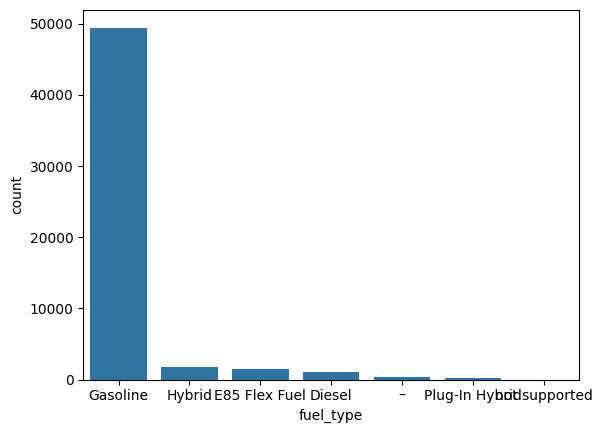

In [ ]:
sns.countplot(x=df['fuel_type'])

In [ ]:
df['fuel_type'].value_counts()

fuel_type
Gasoline          49439
Hybrid             1766
E85 Flex Fuel      1479
Diesel             1109
–                   294
Plug-In Hybrid      182
not supported         4
Name: count, dtype: int64

In [ ]:
df.head(2)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000
1,1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported,Yes,8250


In [ ]:
df.drop(['model','ext_col','int_col','clean_title'],axis=1,errors='ignore', inplace=True)

In [ ]:
df.head(2)

,id,brand,model_year,milage,fuel_type,engine,transmission,accident,price
0,0,Ford,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,None reported,11000
1,1,BMW,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,None reported,8250


In [ ]:
df[['model_year', 'milage']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54273 entries, 0 to 54272
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   model_year  54273 non-null  int64
 1   milage      54273 non-null  int64
dtypes: int64(2)
memory usage: 848.1 KB


In [ ]:
#df['milage']=df['milage'].apply(lambda x:int(x.split('mi')[0].replace(',','')))

In [ ]:
df['fuel_type']=df['fuel_type'].apply(lambda x:
                                      np.nan if str(x).strip()=='–' else
                                      'electric' if str(x).strip()=='not supported' else x)

In [ ]:
df['fuel_type'].value_counts(normalize=True)

fuel_type
Gasoline          0.915893
Hybrid            0.032716
E85 Flex Fuel     0.027400
Diesel            0.020545
Plug-In Hybrid    0.003372
electric          0.000074
Name: proportion, dtype: float64

In [ ]:
hp=df['engine'].apply(lambda x:x.split('HP')[0]).apply(pd.to_numeric,errors='coerce')
liters=df['engine'].apply(lambda x:x.split('L')[0].split('Liter')[0].split(' ')[-1]).apply(pd.to_numeric,errors='coerce')

df['HP']=hp
df['Engine Volume (L)']=liters

df=df.drop(columns='engine')

In [ ]:
df.head(2)

,id,brand,model_year,milage,fuel_type,transmission,accident,price,HP,Engine Volume (L)
0,0,Ford,2018,74349,Gasoline,10-Speed A/T,None reported,11000,375.0,3.5
1,1,BMW,2007,80000,Gasoline,6-Speed M/T,None reported,8250,300.0,3.0


In [ ]:
df['transmission']=df['transmission'].str.contains('A/T|Automatic',case=False).astype(str)

In [ ]:
df['accident']=df['accident'].apply(lambda x:0 if 'None' in str(x) else 1)

In [ ]:
df.head(2)

,id,brand,model_year,milage,fuel_type,transmission,accident,price,HP,Engine Volume (L)
0,0,Ford,2018,74349,Gasoline,True,0,11000,375.0,3.5
1,1,BMW,2007,80000,Gasoline,False,0,8250,300.0,3.0


In [ ]:
#df['price']=df['price'].apply(lambda x:x.replace('$','').replace(',','')).apply(pd.to_numeric)

In [ ]:
df.head()

,id,brand,model_year,milage,fuel_type,transmission,accident,price,HP,Engine Volume (L)
0,0,Ford,2018,74349,Gasoline,True,0,11000,375.0,3.5
1,1,BMW,2007,80000,Gasoline,False,0,8250,300.0,3.0
2,2,Jaguar,2009,91491,Gasoline,True,0,15000,300.0,4.2
3,3,BMW,2022,2437,Hybrid,False,0,63500,335.0,3.0
4,4,Pontiac,2001,111000,Gasoline,True,0,7850,200.0,3.8


<Axes: xlabel='fuel_type', ylabel='count'>

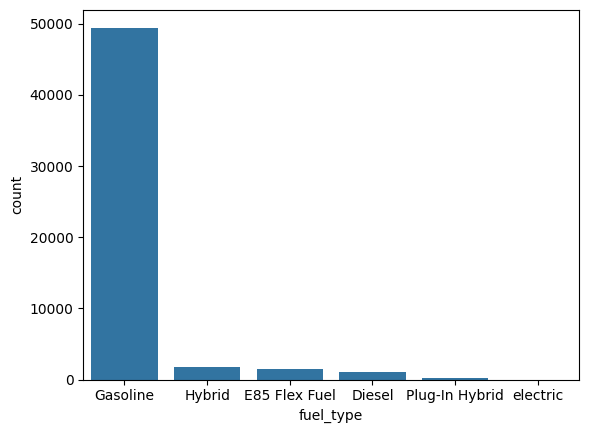

In [ ]:
sns.countplot(x=df['fuel_type'])

<Axes: xlabel='transmission', ylabel='count'>

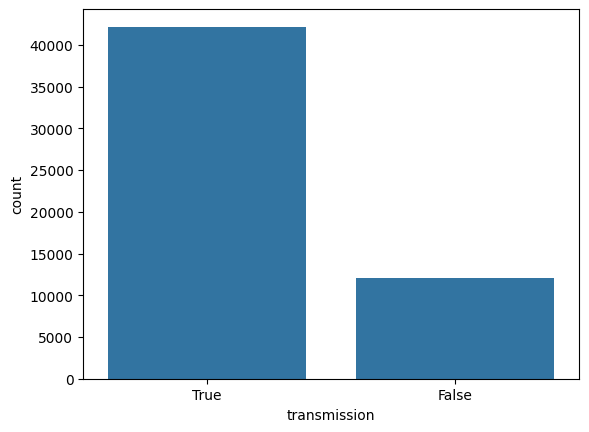

In [ ]:
sns.countplot(x=df['transmission'])

In [ ]:
## Check for missing values

df.isnull().sum()

id                      0
brand                   0
model_year              0
milage                  0
fuel_type             294
transmission            0
accident                0
price                   0
HP                   4057
Engine Volume (L)     606
dtype: int64

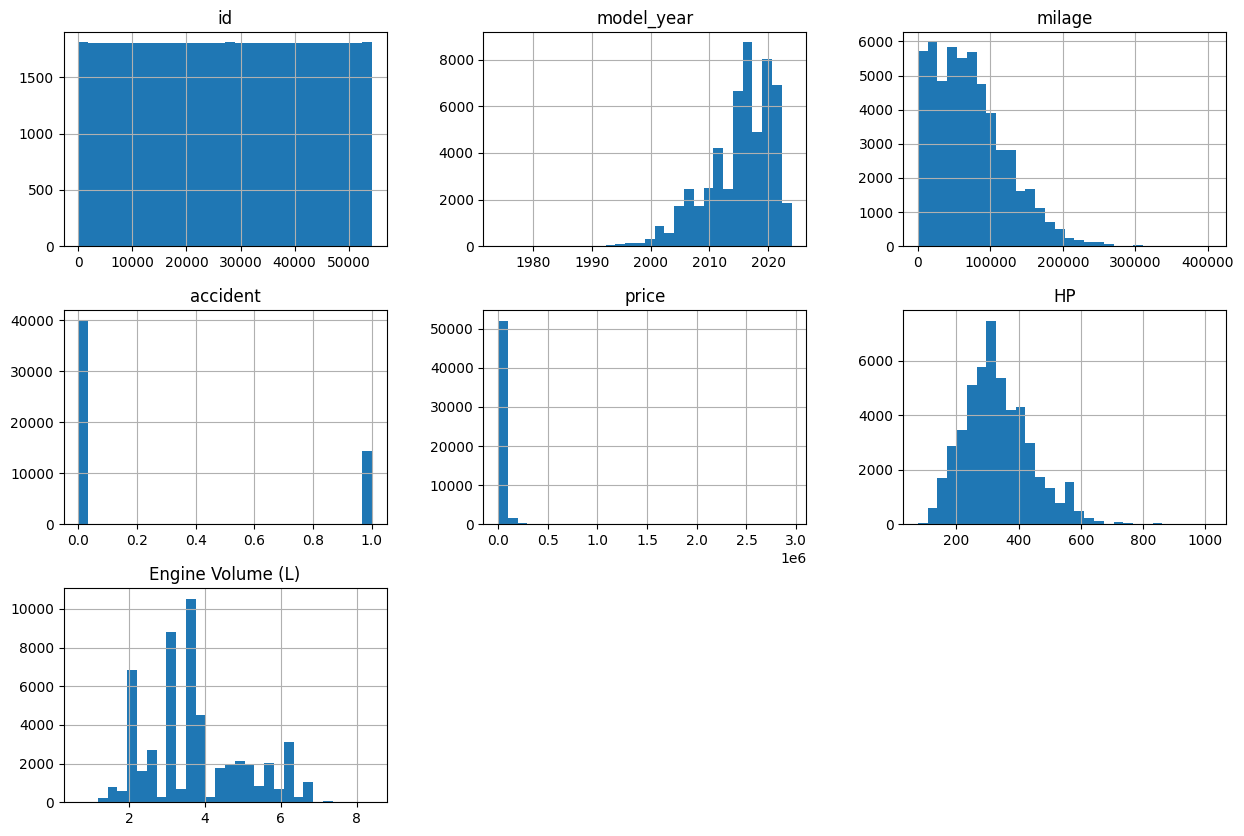

In [ ]:
df.hist(figsize=(15,10),bins=30)
plt.show()

In [ ]:
df.columns

Index(['id', 'brand', 'model_year', 'milage', 'fuel_type', 'transmission',
       'accident', 'price', 'HP', 'Engine Volume (L)'],
      dtype='object')

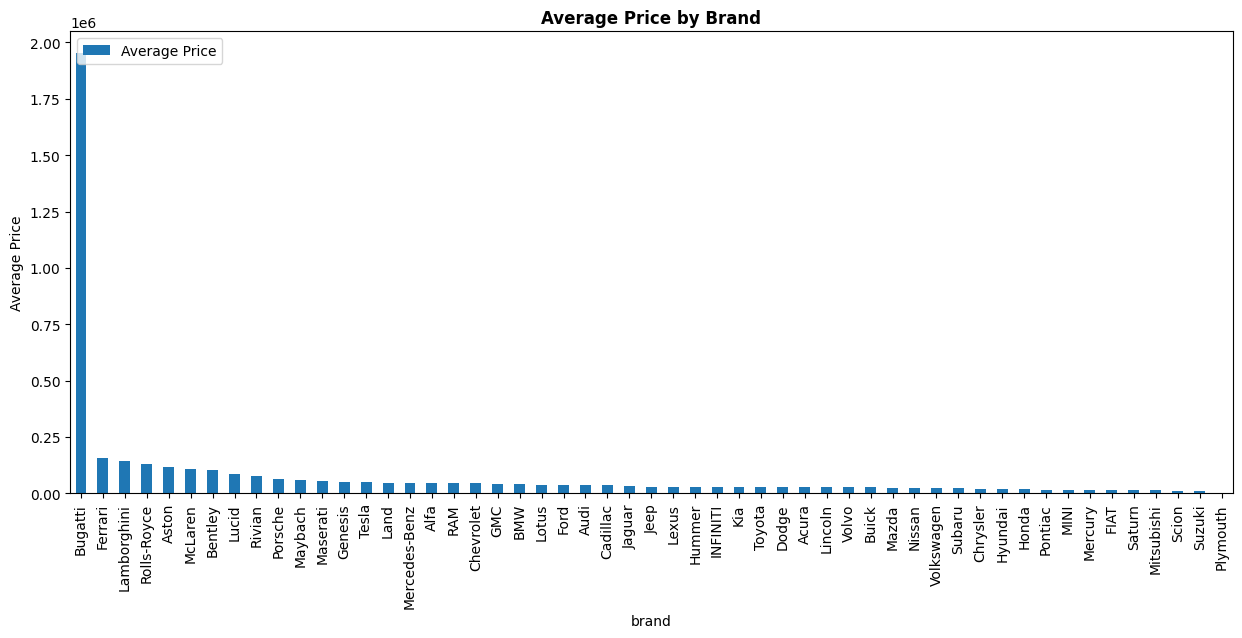

In [ ]:
g=df.groupby('brand').agg({'price':['mean','count']}).sort_values(('price','mean'),ascending=False)

fig,ax=plt.subplots(figsize=(15,6))
#ax2=ax.twinx()
g.plot.bar(ax=ax,y=('price','mean'),label='Average Price')
#g.plot.line(ax=ax2,y=('price','count'),color='blue',ls='--',lw=1,marker='.',label='Number of Instances')

#ax2.axhline(2,ls='--',color='black')

ax.legend(loc='upper left')
#ax2.legend(loc='upper right')
#ax2.set_yscale('log')
ax.set_title('Average Price by Brand',fontweight='bold')
ax.set_ylabel('Average Price')
#ax2.set_ylabel('Number of Instances')
plt.show();

In [ ]:
df['price'].max()

2954083

In [ ]:
df[(df['price'] > 50000) & (df['price'] >= 2954083)]


,id,brand,model_year,milage,fuel_type,transmission,accident,price,HP,Engine Volume (L)
5584,5584,Mercedes-Benz,2004,2533,Gasoline,True,0,2954083,302.0,5.0
7620,7620,Chevrolet,2005,231581,Gasoline,True,0,2954083,400.0,6.0
7849,7849,GMC,2005,231500,Gasoline,True,1,2954083,355.0,5.3
10374,10374,Chevrolet,2015,23442,Gasoline,True,1,2954083,355.0,5.3
13913,13913,Chevrolet,2006,110000,Gasoline,False,1,2954083,355.0,5.3
14389,14389,GMC,2006,231500,Gasoline,True,0,2954083,295.0,5.3
19661,19661,Audi,2017,54500,Diesel,True,1,2954083,NaN,3.0
20007,20007,RAM,2019,10458,Gasoline,True,0,2954083,NaN,5.7
29826,29826,Toyota,2002,17300,Gasoline,True,1,2954083,381.0,5.7
34049,34049,Acura,2021,2353,Gasoline,True,0,2954083,NaN,2.0


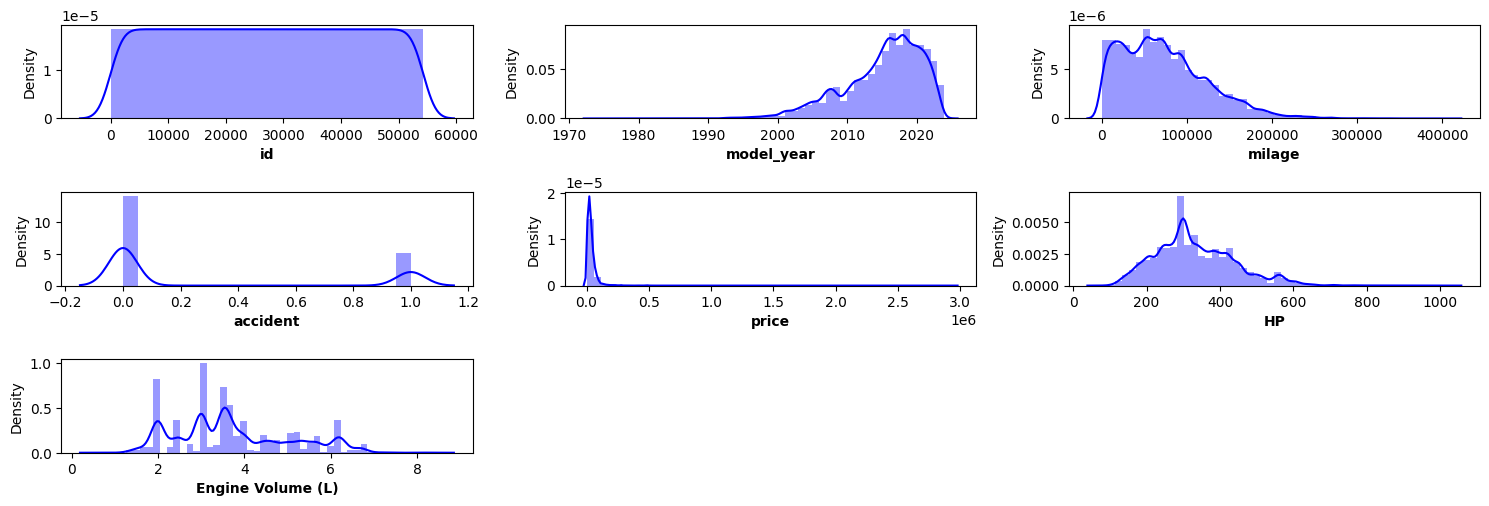

In [ ]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']

plt.figure(figsize=(15, 100))
for i, col in enumerate(numeric_features):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=df[col], color='blue')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

In [ ]:
df.head(2)

,id,brand,model_year,milage,fuel_type,transmission,accident,price,HP,Engine Volume (L)
0,0,Ford,2018,74349,Gasoline,True,0,11000,375.0,3.5
1,1,BMW,2007,80000,Gasoline,False,0,8250,300.0,3.0


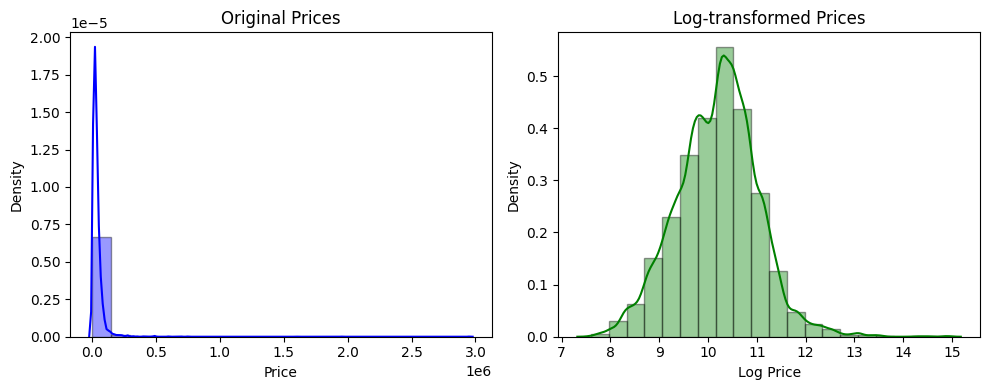

In [ ]:
## Plotting data distribution for Price
original_prices = df['price']

# Log-transformed 'price' column
df['log_price'] = np.log(df['price'] + 1)  # add 1 to handle zero values
log_transformed_prices = df['log_price']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting original prices
sns.distplot(original_prices, bins=20, hist=True, kde=True, color='blue',
             hist_kws={'edgecolor':'black'}, ax=axes[0])
axes[0].set_title('Original Prices')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Density')

# Plotting log-transformed prices
sns.distplot(log_transformed_prices, bins=20, hist=True, kde=True, color='green',
             hist_kws={'edgecolor':'black'}, ax=axes[1])
axes[1].set_title('Log-transformed Prices')
axes[1].set_xlabel('Log Price')
axes[1].set_ylabel('Density')


plt.tight_layout()
plt.show();

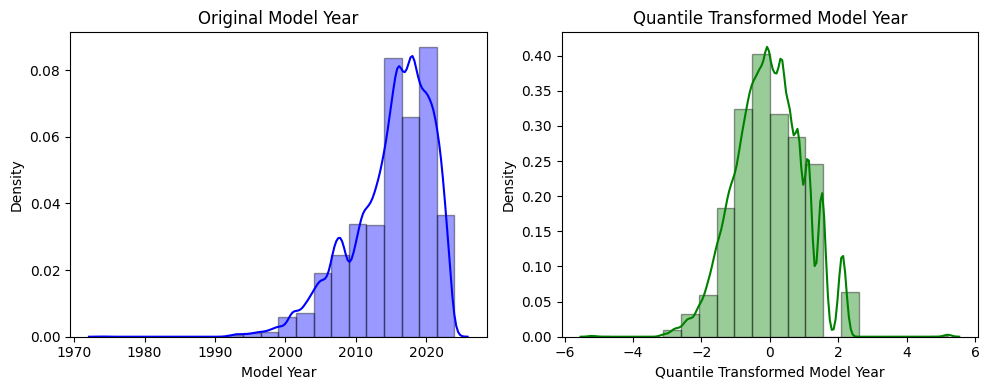

In [ ]:
## Applying Quantile transformation on model year
from sklearn.preprocessing import QuantileTransformer

# Original 'model_year' column
original_model_year = df['model_year']

# Initialize QuantileTransformer with a reasonable number of quantiles
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42) # Changed n_quantiles

# Fit and transform the data
transformed_model_year = qt.fit_transform(df['model_year'].values.reshape(-1, 1))

# Convert transformed array back to DataFrame series
df['model_year_quantile'] = transformed_model_year.flatten()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting original model year
sns.distplot(original_model_year, bins=20, hist=True, kde=True, color='blue',
             hist_kws={'edgecolor':'black'}, ax=axes[0])
axes[0].set_title('Original Model Year')
axes[0].set_xlabel('Model Year')
axes[0].set_ylabel('Density')

# Plotting transformed feature
sns.distplot(transformed_model_year, bins=20, hist=True, kde=True, color='green',
             hist_kws={'edgecolor':'black'}, ax=axes[1])
axes[1].set_title('Quantile Transformed Model Year')
axes[1].set_xlabel('Quantile Transformed Model Year')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()
# ... (rest of the plotting code remains the same)

In [ ]:
df.columns

Index(['id', 'brand', 'model_year', 'milage', 'fuel_type', 'transmission',
       'accident', 'price', 'HP', 'Engine Volume (L)', 'log_price',
       'model_year_quantile'],
      dtype='object')

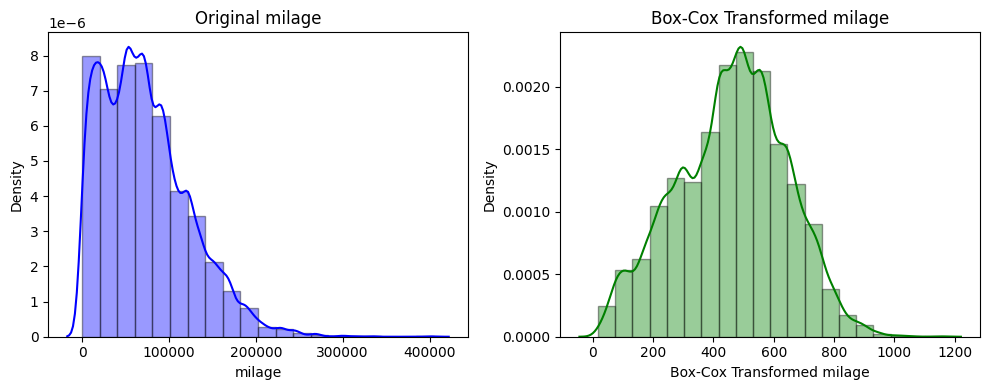

In [ ]:
## Applying Boxcox on milage
from scipy.stats import boxcox

original_mileage = df['milage']

# Apply Box-Cox transformation
transformed_mileage, lambda_value = boxcox(df['milage'] + 1)  # Adding 1 to handle zero and negative values

# Convert transformed array back to DataFrame series
df['milage_boxcox'] = transformed_mileage

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 4))


sns.distplot(original_mileage, bins=20, hist=True, kde=True, color='blue',
             hist_kws={'edgecolor':'black'}, ax=axes[0])
axes[0].set_title('Original milage')
axes[0].set_xlabel('milage')
axes[0].set_ylabel('Density')


sns.distplot(transformed_mileage, bins=20, hist=True, kde=True, color='green',
             hist_kws={'edgecolor':'black'}, ax=axes[1])
axes[1].set_title('Box-Cox Transformed milage')
axes[1].set_xlabel('Box-Cox Transformed milage')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

In [ ]:
df.head(3)

,id,brand,model_year,milage,fuel_type,transmission,accident,price,HP,Engine Volume (L),log_price,model_year_quantile,milage_boxcox
0,0,Ford,2018,74349,Gasoline,True,0,11000,375.0,3.5,9.305741,0.349483,502.528551
1,1,BMW,2007,80000,Gasoline,False,0,8250,300.0,3.0,9.018090,-1.286702,521.028341
2,2,Jaguar,2009,91491,Gasoline,True,0,15000,300.0,4.2,9.615872,-1.020888,556.699700


In [ ]:
df.columns

Index(['id', 'brand', 'model_year', 'milage', 'fuel_type', 'transmission',
       'accident', 'price', 'HP', 'Engine Volume (L)', 'log_price',
       'model_year_quantile', 'milage_boxcox'],
      dtype='object')

In [ ]:
df.drop(columns=['price', 'milage', 'model_year'], axis=1, inplace=True)

In [ ]:
df.head(2)

,id,brand,fuel_type,transmission,accident,HP,Engine Volume (L),log_price,model_year_quantile,milage_boxcox
0,0,Ford,Gasoline,True,0,375.0,3.5,9.305741,0.349483,502.528551
1,1,BMW,Gasoline,False,0,300.0,3.0,9.018090,-1.286702,521.028341


In [ ]:
# Renaming columns

df.rename(columns={
    'log_price': 'price',
    'milage_boxcox': 'mileage',
    'model_year_quantile': 'model_year',
    'Engine Volume (L)': 'engine_volume',
    'HP': 'hp'
}, inplace=True)

In [ ]:
final_df = df.copy(deep=True)

In [ ]:
final_df.head(2)

,id,brand,fuel_type,transmission,accident,hp,engine_volume,price,model_year,mileage
0,0,Ford,Gasoline,True,0,375.0,3.5,9.305741,0.349483,502.528551
1,1,BMW,Gasoline,False,0,300.0,3.0,9.018090,-1.286702,521.028341


In [ ]:
final_df.isnull().sum()

id                  0
brand               0
fuel_type         294
transmission        0
accident            0
hp               4057
engine_volume     606
price               0
model_year          0
mileage             0
dtype: int64

In [ ]:
## Impute the categorical columns

impute_cols = [x for x in final_df.isna().sum()[final_df.isna().sum() != 0].index.tolist()]
for feat in impute_cols:
    mode = final_df[feat].mode()[0]
    final_df[feat].fillna(mode, inplace=True)


## Impute for numerical columns

impute_num_cols = [x for x in final_df.isna().sum()[final_df.isna().sum() != 0].index.tolist()]
for feat in impute_num_cols:
    mode = final_df[feat].median()[0]
    final_df[feat].fillna(median, inplace=True)

In [ ]:
final_df.isnull().sum()

id               0
brand            0
fuel_type        0
transmission     0
accident         0
hp               0
engine_volume    0
price            0
model_year       0
mileage          0
dtype: int64

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54273 entries, 0 to 54272
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             54273 non-null  int64  
 1   brand          54273 non-null  object 
 2   fuel_type      54273 non-null  object 
 3   transmission   54273 non-null  object 
 4   accident       54273 non-null  int64  
 5   hp             54273 non-null  float64
 6   engine_volume  54273 non-null  float64
 7   price          54273 non-null  float64
 8   model_year     54273 non-null  float64
 9   mileage        54273 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 4.1+ MB


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:
final_df.head(2)

,id,brand,fuel_type,transmission,accident,hp,engine_volume,price,model_year,mileage
0,0,Ford,Gasoline,True,0,375.0,3.5,9.305741,0.349483,502.528551
1,1,BMW,Gasoline,False,0,300.0,3.0,9.018090,-1.286702,521.028341


In [ ]:
final_df.to_csv('final_df.csv', index=False)

In [ ]:
X = final_df.drop('price', axis=1)

y = final_df['price']

In [ ]:
numerical_features = X.select_dtypes(exclude="object").columns

numerical_features

Index(['id', 'accident', 'hp', 'engine_volume', 'model_year', 'mileage'], dtype='object')

In [ ]:
final_df[numerical_features].head()

,id,accident,hp,engine_volume,model_year,mileage
0,0,0,375.0,3.5,0.349483,502.528551
1,1,0,300.0,3.0,-1.286702,521.028341
2,2,0,300.0,4.2,-1.020888,556.699700
3,3,0,335.0,3.0,1.517545,92.009772
4,4,0,200.0,3.8,-2.096521,612.389129


In [ ]:
categorical_features = X.select_dtypes(include="object").columns

categorical_features

Index(['brand', 'fuel_type', 'transmission'], dtype='object')

In [ ]:
final_df[categorical_features].head()

,brand,fuel_type,transmission
0,Ford,Gasoline,True
1,BMW,Gasoline,False
2,Jaguar,Gasoline,True
3,BMW,Hybrid,False
4,Pontiac,Gasoline,True


In [ ]:
final_df.to_csv('final_df.csv', index=False)

In [ ]:
df = pd.read_csv('/content/final_df.csv')
df.shape

(54273, 10)

In [ ]:
df.head()

,id,brand,fuel_type,transmission,accident,hp,engine_volume,price,model_year,mileage
0,0,Ford,Gasoline,True,0,375.0,3.5,9.305741,0.349483,502.528551
1,1,BMW,Gasoline,False,0,300.0,3.0,9.018090,-1.286702,521.028341
2,2,Jaguar,Gasoline,True,0,300.0,4.2,9.615872,-1.020888,556.699700
3,3,BMW,Hybrid,False,0,335.0,3.0,11.058811,1.517545,92.009772
4,4,Pontiac,Gasoline,True,0,200.0,3.8,8.968396,-2.096521,612.389129


In [ ]:
X = df.drop('price', axis=1)

y = df['price']

In [ ]:
numerical_features = X.select_dtypes(exclude="object").columns

numerical_features

Index(['id', 'transmission', 'accident', 'hp', 'engine_volume', 'model_year',
       'mileage'],
      dtype='object')

In [ ]:
## Define the pipeline

num_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler())
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ordinalencoder", OrdinalEncoder()),
    ]
)

In [ ]:
transformer = ColumnTransformer(transformers=[
   ("OrdinalEncoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
    ("RobustScaler", RobustScaler(), numerical_features)
], remainder="passthrough")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import learning_curve

def plot_learning_curve(model):
    train_sizes,train_scores,test_scores=learning_curve(
        X=X_train,
        y=y_train,
        estimator=model,
        train_sizes=np.linspace(0.1,1,10),
        cv=3,
        scoring='neg_root_mean_squared_error',
        verbose=1
    )

    train_scores_mean=np.mean(train_scores,axis=1)
    train_scores_std=np.std(train_scores,axis=1)
    test_scores_mean=np.mean(test_scores,axis=1)
    test_scores_std=np.std(test_scores,axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', color='blue')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')
    plt.plot(train_sizes, test_scores_mean, label='Validation Accuracy', color='red')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='red')
    plt.xlabel('Training Set Size')
    plt.ylabel('MAE')
    plt.title('Learning Curve for XGBoost Classifier')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

[learning_curve] Training set sizes: [ 2894  5789  8683 11578 14472 17367 20261 23156 26050 28945]


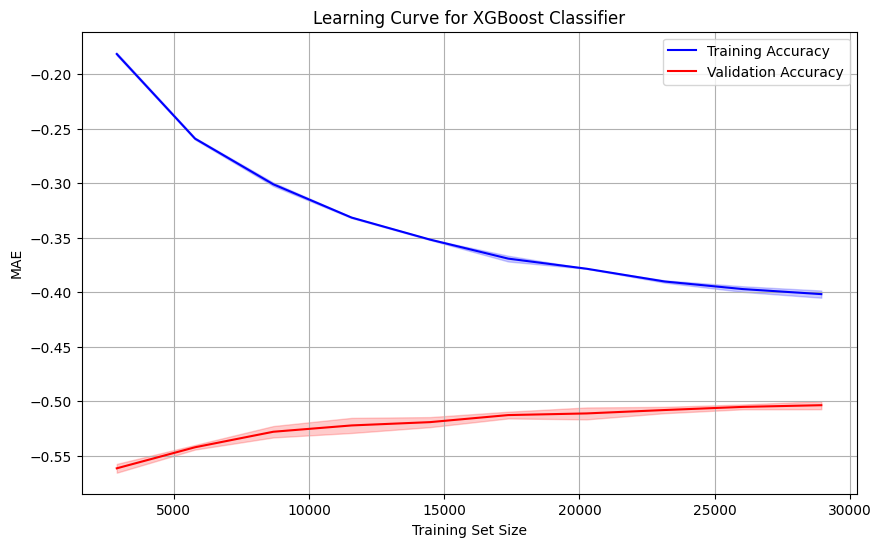

In [ ]:
plot_learning_curve(XGBRegressor())

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV

param_grid={'n_estimators':[100,500,1000,2000],
            'max_depth':[3,5,8,10],
            'learning_rate':[0.01,0.05,0.1,0.15]}

grid_search_cv=GridSearchCV(estimator=XGBRegressor(),
                         param_grid=param_grid,
                         scoring='neg_root_mean_squared_error',
                         cv=3,
                         verbose=10)

grid_search_cv.fit(X_train,y_train)

best_model=grid_search_cv.best_estimator_
print(grid_search_cv.best_estimator_)
print(grid_search_cv.best_score_)
print(grid_search_cv.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV 1/3; 1/64] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 1/3; 1/64] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.583 total time=   0.2s
[CV 2/3; 1/64] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 2/3; 1/64] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.584 total time=   0.2s
[CV 3/3; 1/64] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 3/3; 1/64] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.584 total time=   0.2s
[CV 1/3; 2/64] START learning_rate=0.01, max_depth=3, n_estimators=500..........
[CV 1/3; 2/64] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=-0.507 total time=   2.7s
[CV 2/3; 2/64] START learning_rate=0.01, max_depth=3, n_estimators=500..........
[CV 2/3; 2/64] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=-0.501 total time=   1.0s
[CV 3/3; 2/64] STA

[learning_curve] Training set sizes: [ 2894  5789  8683 11578 14472 17367 20261 23156 26050 28945]


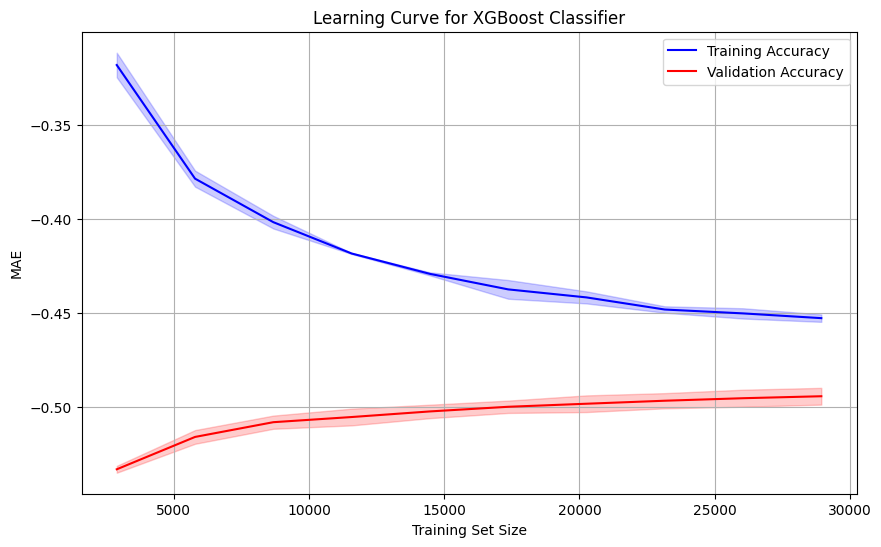

In [ ]:
plot_learning_curve(best_model)

In [ ]:
train_prediction=best_model.predict(X_train)
test_prediction=best_model.predict(X_test)

In [ ]:
from sklearn import metrics

r2_train=metrics.r2_score(train_prediction,y_train)
r2_test=metrics.r2_score(test_prediction,y_test)
mae_train=metrics.mean_absolute_error(train_prediction,y_train)
mae_test=metrics.mean_absolute_error(test_prediction,y_test)
rmse_train=metrics.mean_squared_error(train_prediction,y_train,squared=False)
rmse_test=metrics.mean_squared_error(test_prediction,y_test,squared=False)
train_scores={'R2_train':r2_train,'MAE_train':mae_train,'RMSE_train':rmse_train}
test_scores={'R2_test':r2_test,'MAE_test':mae_test,'RMSE_test':rmse_test}
print(train_scores)
print(test_scores)

{'R2_train': 0.5245183829031064, 'MAE_train': 0.3204375704004526, 'RMSE_train': 0.4617681189494372}
{'R2_test': 0.4767348457084527, 'MAE_test': 0.33256516945198866, 'RMSE_test': 0.4804463862965435}


In [ ]:
def Training(model, X_train, X_test, y_train, y_test):
    model = model()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    error = mean_absolute_error(y_test, predictions)
    return error

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error

def Training(model, X_train, X_test, y_train, y_test):
    model = model()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    error = mean_squared_error(y_test, predictions)
    return error

rf_error = Training(RandomForestRegressor, X_train, X_test, y_train, y_test)

hb_error = Training(HuberRegressor, X_train, X_test, y_train, y_test)

lr_error = Training(LinearRegression, X_train, X_test, y_train, y_test)

dt_error = Training(DecisionTreeRegressor, X_train, X_test, y_train, y_test)

ab_error = Training(AdaBoostRegressor, X_train, X_test, y_train, y_test)

gb_error = Training(GradientBoostingRegressor, X_train, X_test, y_train, y_test)

# Gaussian Naive Bayes is for classification problems. It expects discrete class labels, not continuous values.
# If your problem is regression (predicting a continuous value), you should not use GaussianNB.
# Commenting out the line below to avoid the error.
# nb_error=Training(GaussianNB, X_train, X_test, y_train, y_test)

print("Random Forest Error:", rf_error)
print("Huber Regressor Error:", hb_error)
print("Linear Regression Error:", lr_error)
print("Decision Tree Regressor Error:", dt_error)
print("AdaBoost Regressor Error:", ab_error)
print("Gradient Boosting Regressor Error:", gb_error)

Random Forest Error: 0.24782011818510274
Huber Regressor Error: 0.27233281064802556
Linear Regression Error: 0.2719001737662629
Decision Tree Regressor Error: 0.5074824838703914
AdaBoost Regressor Error: 0.3728596952333595
Gradient Boosting Regressor Error: 0.23781671184319553


In [ ]:
names = list(Errors.keys())
values = list(Errors.values())

<BarContainer object of 6 artists>

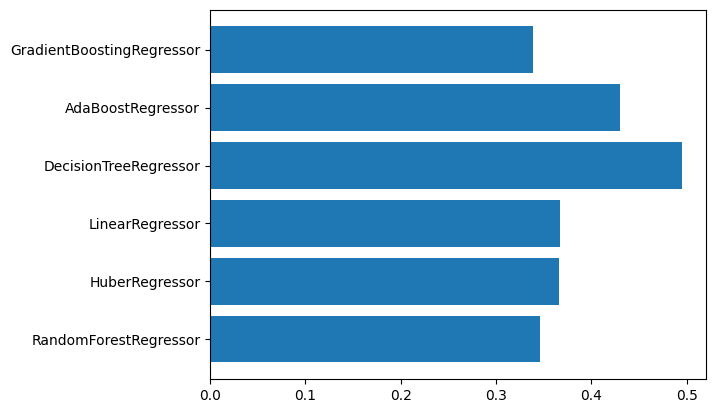

In [ ]:
plt.barh(range(len(Errors)), values, tick_label=names)

In [ ]:
test=pd.read_csv("/content/test.csv")
test.head(3)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,54273,Mercedes-Benz,E-Class E 350,2014,73000,Gasoline,302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,White,Beige,None reported,Yes
1,54274,Lexus,RX 350 Base,2015,128032,Gasoline,275.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Silver,Black,None reported,Yes
2,54275,Mercedes-Benz,C-Class C 300,2015,51983,Gasoline,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Blue,White,None reported,Yes


In [ ]:
test.head(2)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,54273,Mercedes-Benz,E-Class E 350,2014,73000,Gasoline,302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,White,Beige,None reported,Yes
1,54274,Lexus,RX 350 Base,2015,128032,Gasoline,275.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Silver,Black,None reported,Yes


In [ ]:
test.drop(['model','ext_col','int_col','clean_title'],axis=1,errors='ignore', inplace=True)



In [ ]:
test[['model_year', 'milage']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36183 entries, 0 to 36182
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   model_year  36183 non-null  int64
 1   milage      36183 non-null  int64
dtypes: int64(2)
memory usage: 565.5 KB


In [ ]:
test['fuel_type']=test['fuel_type'].apply(lambda x:
                                      np.nan if str(x).strip()=='–' else
                                      'electric' if str(x).strip()=='not supported' else x)

In [ ]:
test['fuel_type'].value_counts(normalize=True)

fuel_type
Gasoline          0.917940
Hybrid            0.030901
E85 Flex Fuel     0.028289
Diesel            0.018646
Plug-In Hybrid    0.004113
electric          0.000111
Name: proportion, dtype: float64

In [ ]:
test.head(2)

,id,brand,model_year,milage,fuel_type,engine,transmission,accident
0,54273,Mercedes-Benz,2014,73000,Gasoline,302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,None reported
1,54274,Lexus,2015,128032,Gasoline,275.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,None reported


In [ ]:
# Check if 'engine' column exists before processing
if 'engine' in test.columns:
    hp=test['engine'].apply(lambda x:x.split('HP')[0]).apply(pd.to_numeric,errors='coerce')
    liters=test['engine'].apply(lambda x:x.split('L')[0].split('Liter')[0].split(' ')[-1]).apply(pd.to_numeric,errors='coerce')

    test['HP']=hp
    test['Engine Volume (L)']=liters

    test=test.drop(columns='engine')
else:
    print("Column 'engine' not found in the DataFrame.")

In [ ]:
test['transmission']=test['transmission'].str.contains('A/T|Automatic',case=False).astype(str)

In [ ]:
test['accident']=test['accident'].apply(lambda x:0 if 'None' in str(x) else 1)

In [ ]:
test.columns

Index(['id', 'brand', 'model_year', 'milage', 'fuel_type', 'transmission',
       'accident', 'HP', 'Engine Volume (L)'],
      dtype='object')

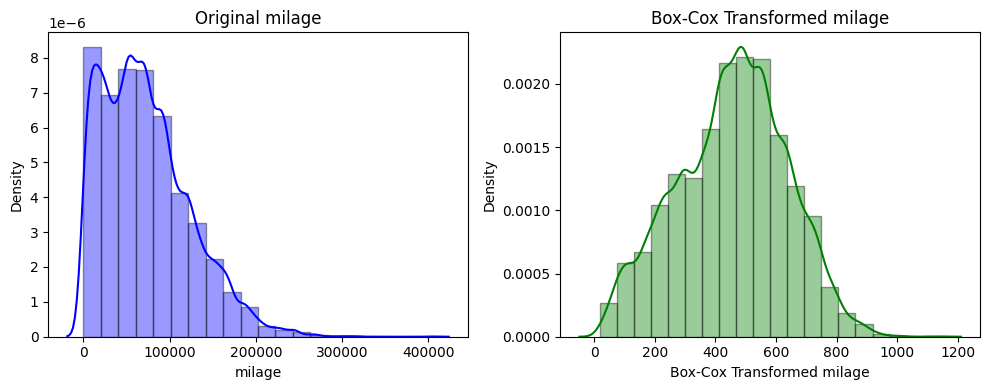

In [ ]:
## Applying Boxcox on milage
from scipy.stats import boxcox

original_mileage = test['milage']

# Apply Box-Cox transformation
transformed_mileage, lambda_value = boxcox(test['milage'] + 1)  # Adding 1 to handle zero and negative values

# Convert transformed array back to DataFrame series
test['milage_boxcox'] = transformed_mileage

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 4))


sns.distplot(original_mileage, bins=20, hist=True, kde=True, color='blue',
             hist_kws={'edgecolor':'black'}, ax=axes[0])
axes[0].set_title('Original milage')
axes[0].set_xlabel('milage')
axes[0].set_ylabel('Density')


sns.distplot(transformed_mileage, bins=20, hist=True, kde=True, color='green',
             hist_kws={'edgecolor':'black'}, ax=axes[1])
axes[1].set_title('Box-Cox Transformed milage')
axes[1].set_xlabel('Box-Cox Transformed milage')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

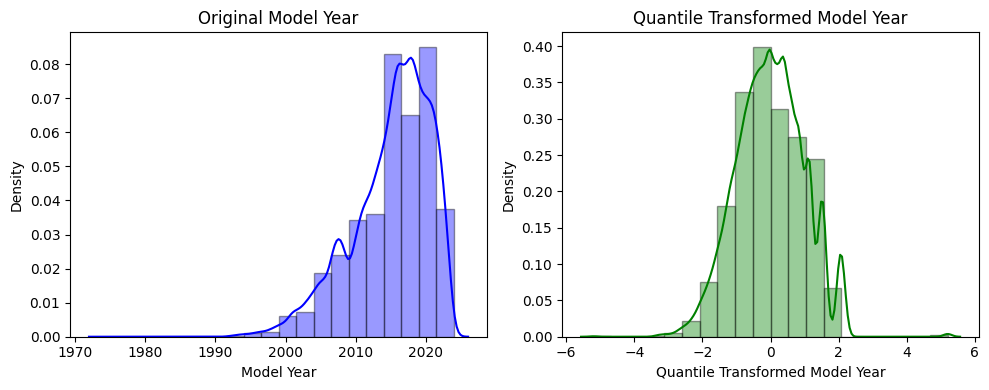

In [ ]:
## Applying Quantile transformation on model year
from sklearn.preprocessing import QuantileTransformer

# Original 'model_year' column
original_model_year = test['model_year']

# Initialize QuantileTransformer with a reasonable number of quantiles
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42) # Changed n_quantiles

# Fit and transform the data
transformed_model_year = qt.fit_transform(test['model_year'].values.reshape(-1, 1))

# Convert transformed array back to DataFrame series
test['model_year_quantile'] = transformed_model_year.flatten()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting original model year
sns.distplot(original_model_year, bins=20, hist=True, kde=True, color='blue',
             hist_kws={'edgecolor':'black'}, ax=axes[0])
axes[0].set_title('Original Model Year')
axes[0].set_xlabel('Model Year')
axes[0].set_ylabel('Density')

# Plotting transformed feature
sns.distplot(transformed_model_year, bins=20, hist=True, kde=True, color='green',
             hist_kws={'edgecolor':'black'}, ax=axes[1])
axes[1].set_title('Quantile Transformed Model Year')
axes[1].set_xlabel('Quantile Transformed Model Year')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()
# ... (rest of the plotting code remains the same)

In [ ]:
test.head(3)

,id,brand,model_year,milage,fuel_type,transmission,accident,HP,Engine Volume (L),milage_boxcox,model_year_quantile
0,54273,Mercedes-Benz,2014,73000,Gasoline,True,0,302.0,3.5,492.491439,-0.397918
1,54274,Lexus,2015,128032,Gasoline,True,0,275.0,3.5,649.338969,-0.234219
2,54275,Mercedes-Benz,2015,51983,Gasoline,True,0,241.0,2.0,416.646228,-0.234219


In [ ]:
test.drop(columns=['milage', 'model_year'], axis=1, inplace=True)

In [ ]:
# Renaming columns

test.rename(columns={
    'milage_boxcox': 'mileage',
    'model_year_quantile': 'model_year',
    'Engine Volume (L)': 'engine_volume',
    'HP': 'hp'
}, inplace=True)

In [ ]:
final_test=test.copy(deep=True)

In [ ]:
final_test.head(2)

,id,brand,fuel_type,transmission,accident,hp,engine_volume,mileage,model_year
0,54273,Mercedes-Benz,Gasoline,True,0,302.0,3.5,492.491439,-0.397918
1,54274,Lexus,Gasoline,True,0,275.0,3.5,649.338969,-0.234219


In [ ]:
final_test.isnull().sum()

id                  0
brand               0
fuel_type         197
transmission        0
accident            0
hp               2606
engine_volume     405
mileage             0
model_year          0
dtype: int64

In [ ]:
## Impute the categorical columns

impute_cols = [x for x in final_test.isna().sum()[final_test.isna().sum() != 0].index.tolist()]
for feat in impute_cols:
    mode = final_test[feat].mode()[0]
    final_test[feat].fillna(mode, inplace=True)


## Impute for numerical columns

impute_num_cols = [x for x in final_test.isna().sum()[final_test.isna().sum() != 0].index.tolist()]
for feat in impute_num_cols:
    mode = final_test[feat].median()[0]
    final_test[feat].fillna(median, inplace=True)

In [ ]:
final_test.isnull().sum()

id               0
brand            0
fuel_type        0
transmission     0
accident         0
hp               0
engine_volume    0
mileage          0
model_year       0
dtype: int64

In [ ]:
final_test.to_csv('final_test.csv', index=False)

In [ ]:
numerical_features = final_test.select_dtypes(exclude="object").columns

numerical_features

Index(['id', 'accident', 'hp', 'engine_volume', 'mileage', 'model_year'], dtype='object')

In [ ]:
categorical_features = final_test.select_dtypes(include="object").columns

categorical_features

Index(['brand', 'fuel_type', 'transmission'], dtype='object')

In [ ]:
final_test.to_csv('final_test.csv', index=False)

In [ ]:
test = pd.read_csv('/content/final_test.csv')

In [ ]:
x_test=test.copy()
x_test=transformer.transform(x_test)

In [ ]:
!pip install scikit-learn
import sklearn.metrics as metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


model = HuberRegressor()
model.fit(X_train, y_train)
train_predictions=model.predict(X_train)
test_predictions=model.predict(X_test)
# Use metrics from sklearn
rmse_train=metrics.mean_squared_error(train_predictions,y_train,squared=False) # Fixed typo: train_prediction -> train_predictions
rmse_test=metrics.mean_squared_error(test_predictions,y_test,squared=False)  # Fixed typo: test_prediction -> test_predictions
train_scores={'RMSE_train':rmse_train}
test_scores={'RMSE_test':rmse_test}
print(train_scores)
print(test_scores)
predictions = model.predict(x_test)

{'RMSE_train': 0.5289602637120503}
{'RMSE_test': 0.5218551625192813}


In [ ]:
predictions1=best_model.predict(x_test)

In [ ]:
op1=pd.DataFrame({'id': test.id, 'price': predictions1})
op1['price']=np.exp(op1['price'])
op1.head(5)

,id,price
0,54273,20583.601562
1,54274,17026.220703
2,54275,26412.708984
3,54276,50611.832031
4,54277,31991.093750


In [ ]:
predictions

array([ 9.99376679,  9.8116347 , 10.10687656, ...,  9.10299929,
       10.83396046,  9.40404751])

In [ ]:
op = pd.DataFrame({'id': test.id, 'price': predictions})

In [ ]:
op.head(5)

,id,price
0,54273,21889.597276
1,54274,18244.787387
2,54275,24510.982444
3,54276,52440.382859
4,54277,29331.166546


In [ ]:
op['price']=np.exp(op['price'])
op.head(5)

,id,price
0,54273,21889.597276
1,54274,18244.787387
2,54275,24510.982444
3,54276,52440.382859
4,54277,29331.166546


In [ ]:
op1.to_csv('output.csv', index=False)